# • Probabilistic Forecasts

Making predictions for the future involves varying degrees of imperfect or unknown information that translates into uncertainty. For this reason, probabilistic forecasting has emerged as a natural answer to quantify the uncertainty of the future of the target variable, conditioning on the available information of its predictors.

In this notebok we extend the [NHITS](https://arxiv.org/abs/2201.12886) and [NBEATS](https://arxiv.org/abs/1905.10437) models for the probabilistic forecasting task in long horizon settings, to overcome the limitated information of point forecasting, by combining the NHITS/NBEATS model with the multi quantile loss function into the [MQ-NHITS/MQ-NBEATS] model we enable its outputs to produce at any time $t$ a predictive distribution:

$$\mathbb{P}(\mathbf{y}_{t+1:t+H} \;|\; \mathbf{y}_{:t})$$

For the experimental setting we chose the M4-Hourly data and compute the prediction intervals,  using the Multi Quantile Loss (MQLoss).

$$ \mathrm{MQLoss}(y_{\tau}, [\hat{y}^{(q1)}_{\tau},\hat{y}^{(q2)}_{\tau},\dots,\hat{y}^{(Q)}_{\tau}]) = \frac{1}{H} \sum_{q} \mathrm{QL}(y_{\tau}, \hat{y}^{(q)}_{\tau}) $$

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/UncertaintyIntervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
%%capture
!pip install neuralforecast matplotlib
!pip install statsforecast

In [ ]:
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.losses.pytorch import MQLoss

#### Useful functions

The `plot_grid` function defined below will be useful to plot different time series, and different models' forecasts.

In [ ]:
def plot_grid(df_train, df_test=None, plot_random=True, model=None, level=None):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            for col in ['y', f'{model}-median', 'y_test']:
                if col in test_uid:
                    axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)
            if level is not None:
                for l, alpha in zip(sorted(level), [0.5, .4, .35, .2]):
                    axes[idx, idy].fill_between(
                        test_uid['ds'], 
                        test_uid[f'{model}-lo-{l}'], 
                        test_uid[f'{model}-hi-{l}'],
                        alpha=alpha,
                        color='orange',
                        label=f'{model}_level_{l}',
                    )
        axes[idx, idy].set_title(f'M4 Hourly: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

## 2. Loading M4 Data

For testing purposes, we will use the Hourly dataset from the M4 competition.

In [ ]:
%%capture
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv

In [ ]:
Y_train_df = pd.read_csv('M4-Hourly.csv')
Y_test_df = pd.read_csv('M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long. You can modify the number of series if you want.

In [ ]:
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

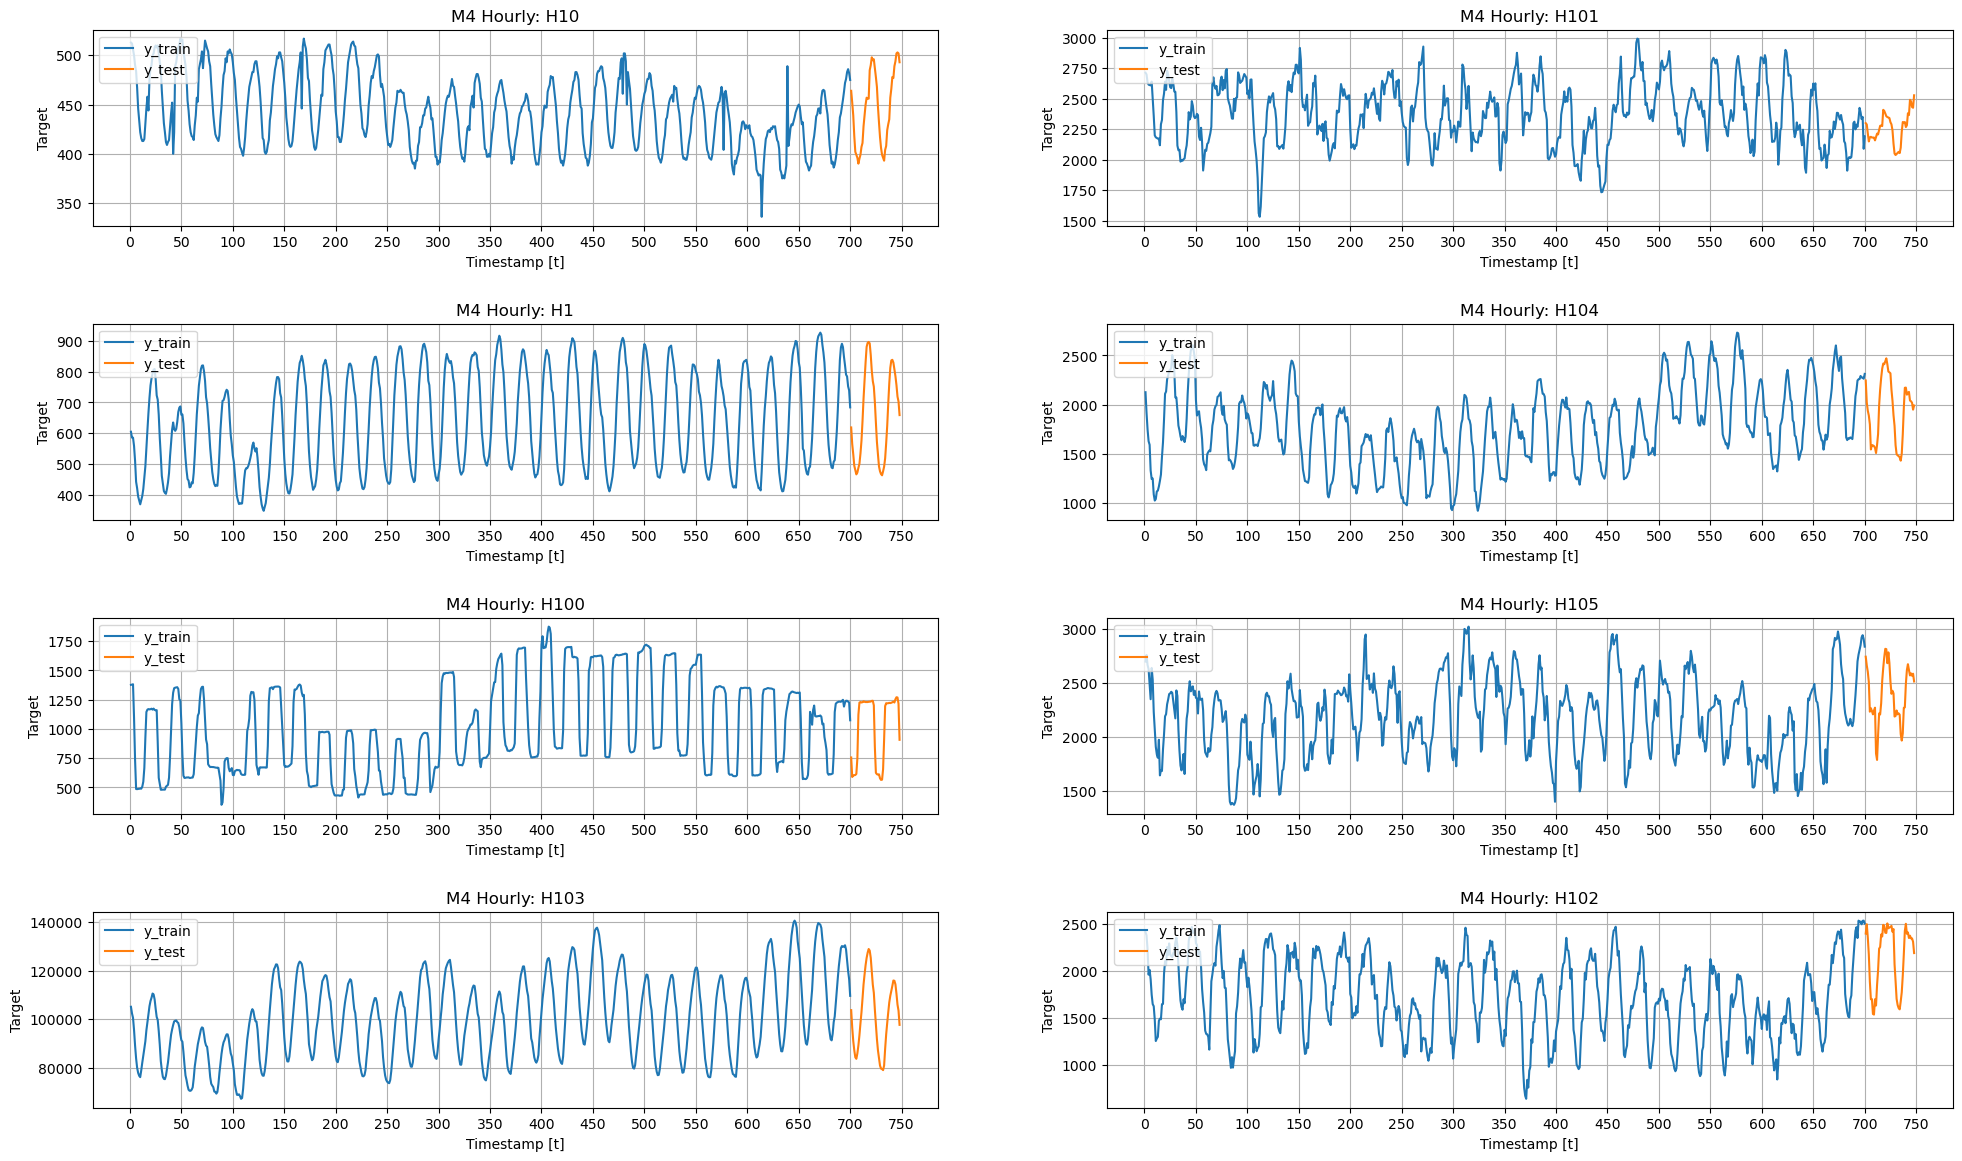

In [ ]:
plot_grid(Y_train_df, Y_test_df)

## 3. Model Training

`NeuralForecast` receives a list of models to fit each time series. We can define the level of the forecast intervals we want to produce using the multiquantile loss (`MQLoss`). `NeuralForecast` will produce these levels.

In [ ]:
horizon = 48
levels = [80, 90, 95, 99]
models = [NBEATS(input_size=3 * horizon, h=horizon, 
                 loss=MQLoss(level=levels), max_epochs=100),
          NHITS(input_size=3 * horizon, h=horizon, 
                 loss=MQLoss(level=levels), max_epochs=100),]
fcst = NeuralForecast(models=models, freq='H')

In [ ]:
%%capture
fcst.fit(df=Y_train_df)

In [ ]:
forecasts = fcst.predict()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
forecasts = forecasts.reset_index()

In [ ]:
forecasts.head()

,unique_id,ds,NBEATS-median,NBEATS-lo-99,NBEATS-lo-95,NBEATS-lo-90,NBEATS-lo-80,NBEATS-hi-80,NBEATS-hi-90,NBEATS-hi-95,NBEATS-hi-99,NHITS-median,NHITS-lo-99,NHITS-lo-95,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,NHITS-hi-95,NHITS-hi-99
0,H1,701,642.484070,523.299988,593.359314,607.420288,617.271545,699.356934,848.147339,692.430481,788.037720,575.489380,352.734283,209.175079,618.708618,582.936218,733.099609,642.886475,704.783081,856.671875
1,H1,702,573.721191,443.613770,394.546906,572.768799,570.042908,747.334717,749.886780,707.505493,1008.247192,549.540588,258.061035,338.497559,397.430481,544.787964,567.741882,553.846008,609.820068,643.173340
2,H1,703,545.898315,266.493805,242.920837,496.043427,516.764954,553.762695,574.191895,674.188049,751.233154,418.858521,239.225723,319.820801,511.904480,487.105835,762.195190,662.528320,706.905334,801.801270
3,H1,704,535.179443,308.732361,427.288757,482.331177,464.451355,543.035522,615.674988,706.465454,584.426025,444.324280,299.847290,415.556335,414.385681,437.597443,463.270325,564.293152,604.986328,651.928345
4,H1,705,500.951477,209.410126,339.495483,430.764191,407.461212,535.958435,586.766846,535.642639,910.100952,415.464661,141.160614,369.852173,431.824402,380.319672,462.463806,524.772949,738.223328,678.019409


In [ ]:
Y_test_df = Y_test_df.merge(forecasts, how='left', on=['unique_id', 'ds'])

## 4. Plotting Predictions

Then we can plot the prediction intervals for each model as follows.

### MQ-NBEATS

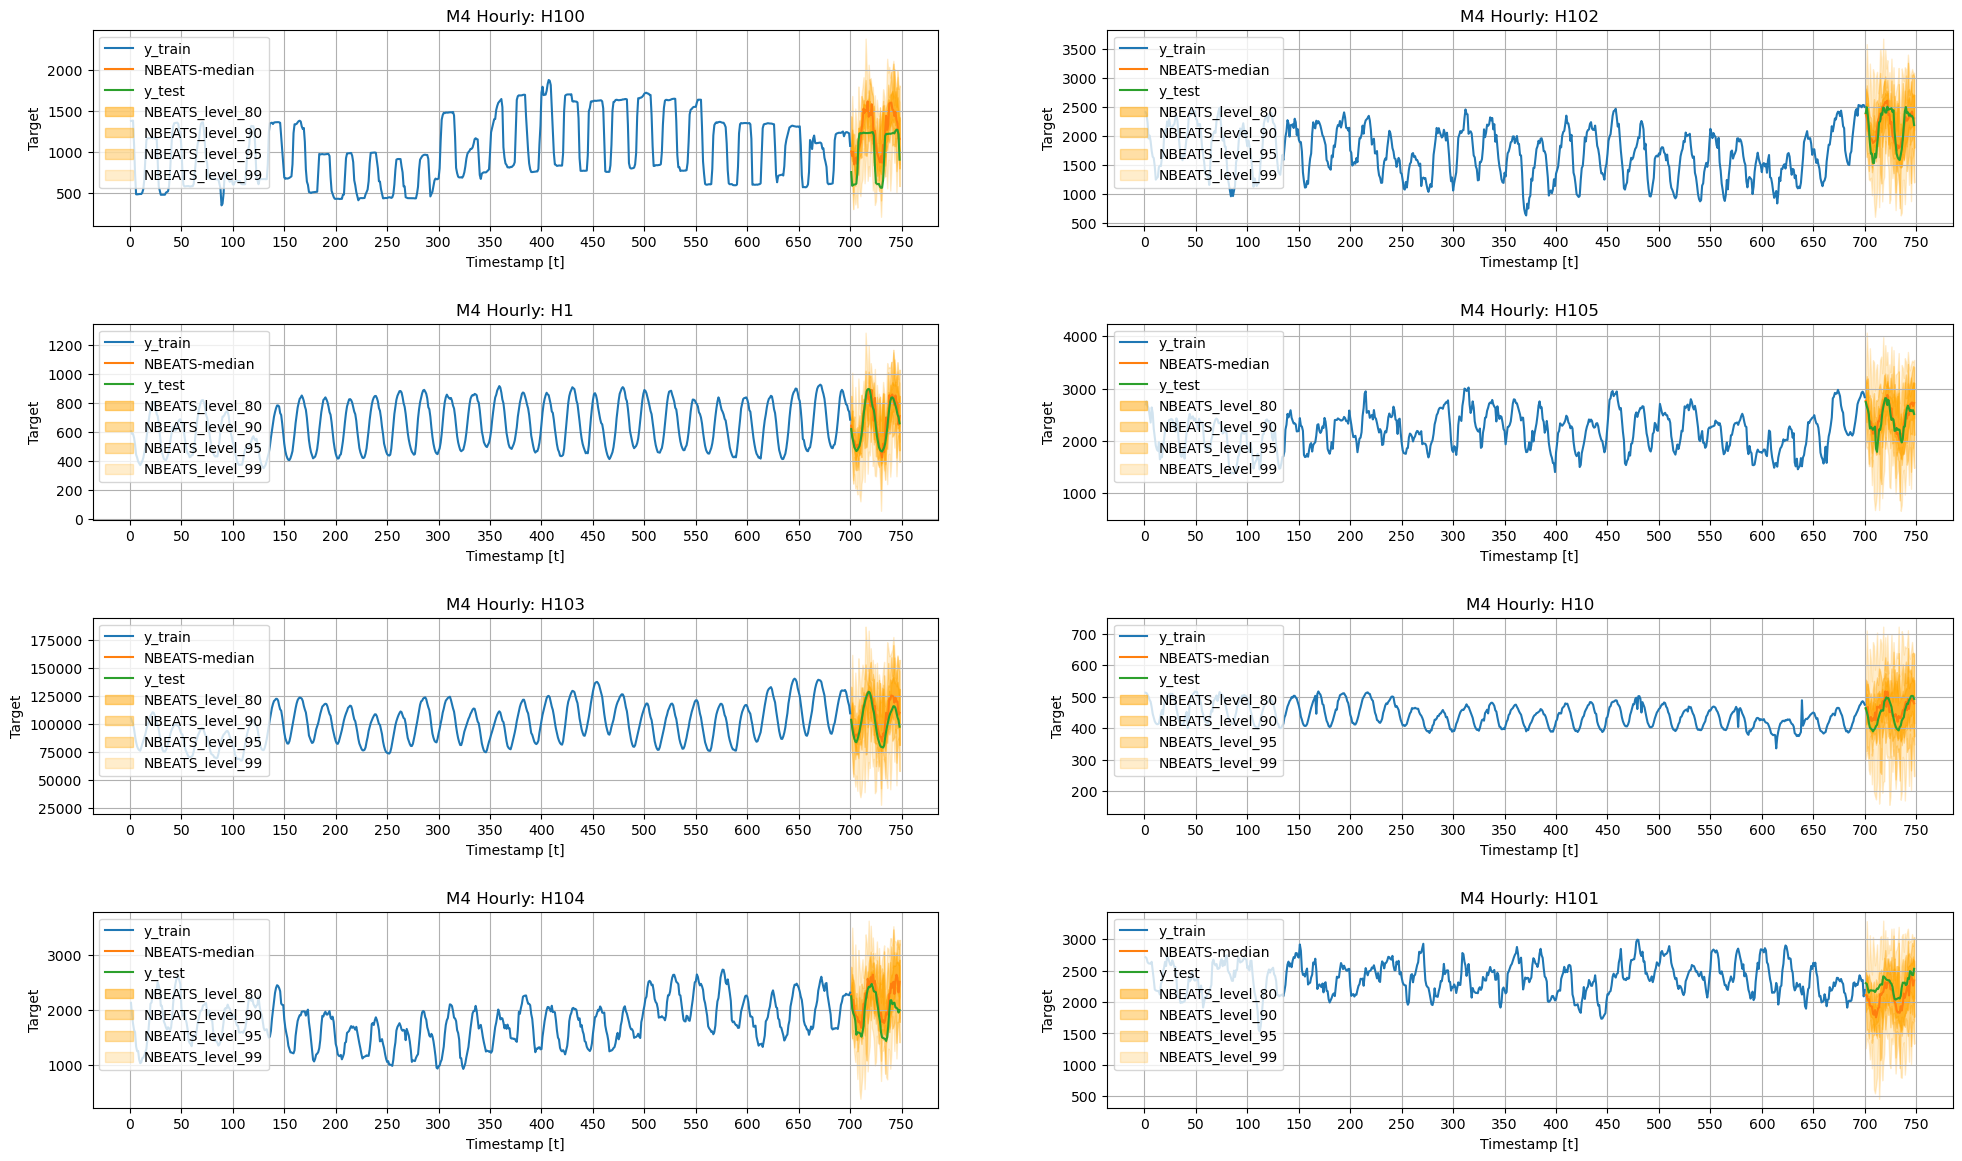

In [ ]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='NBEATS')

### MQ-NHITS

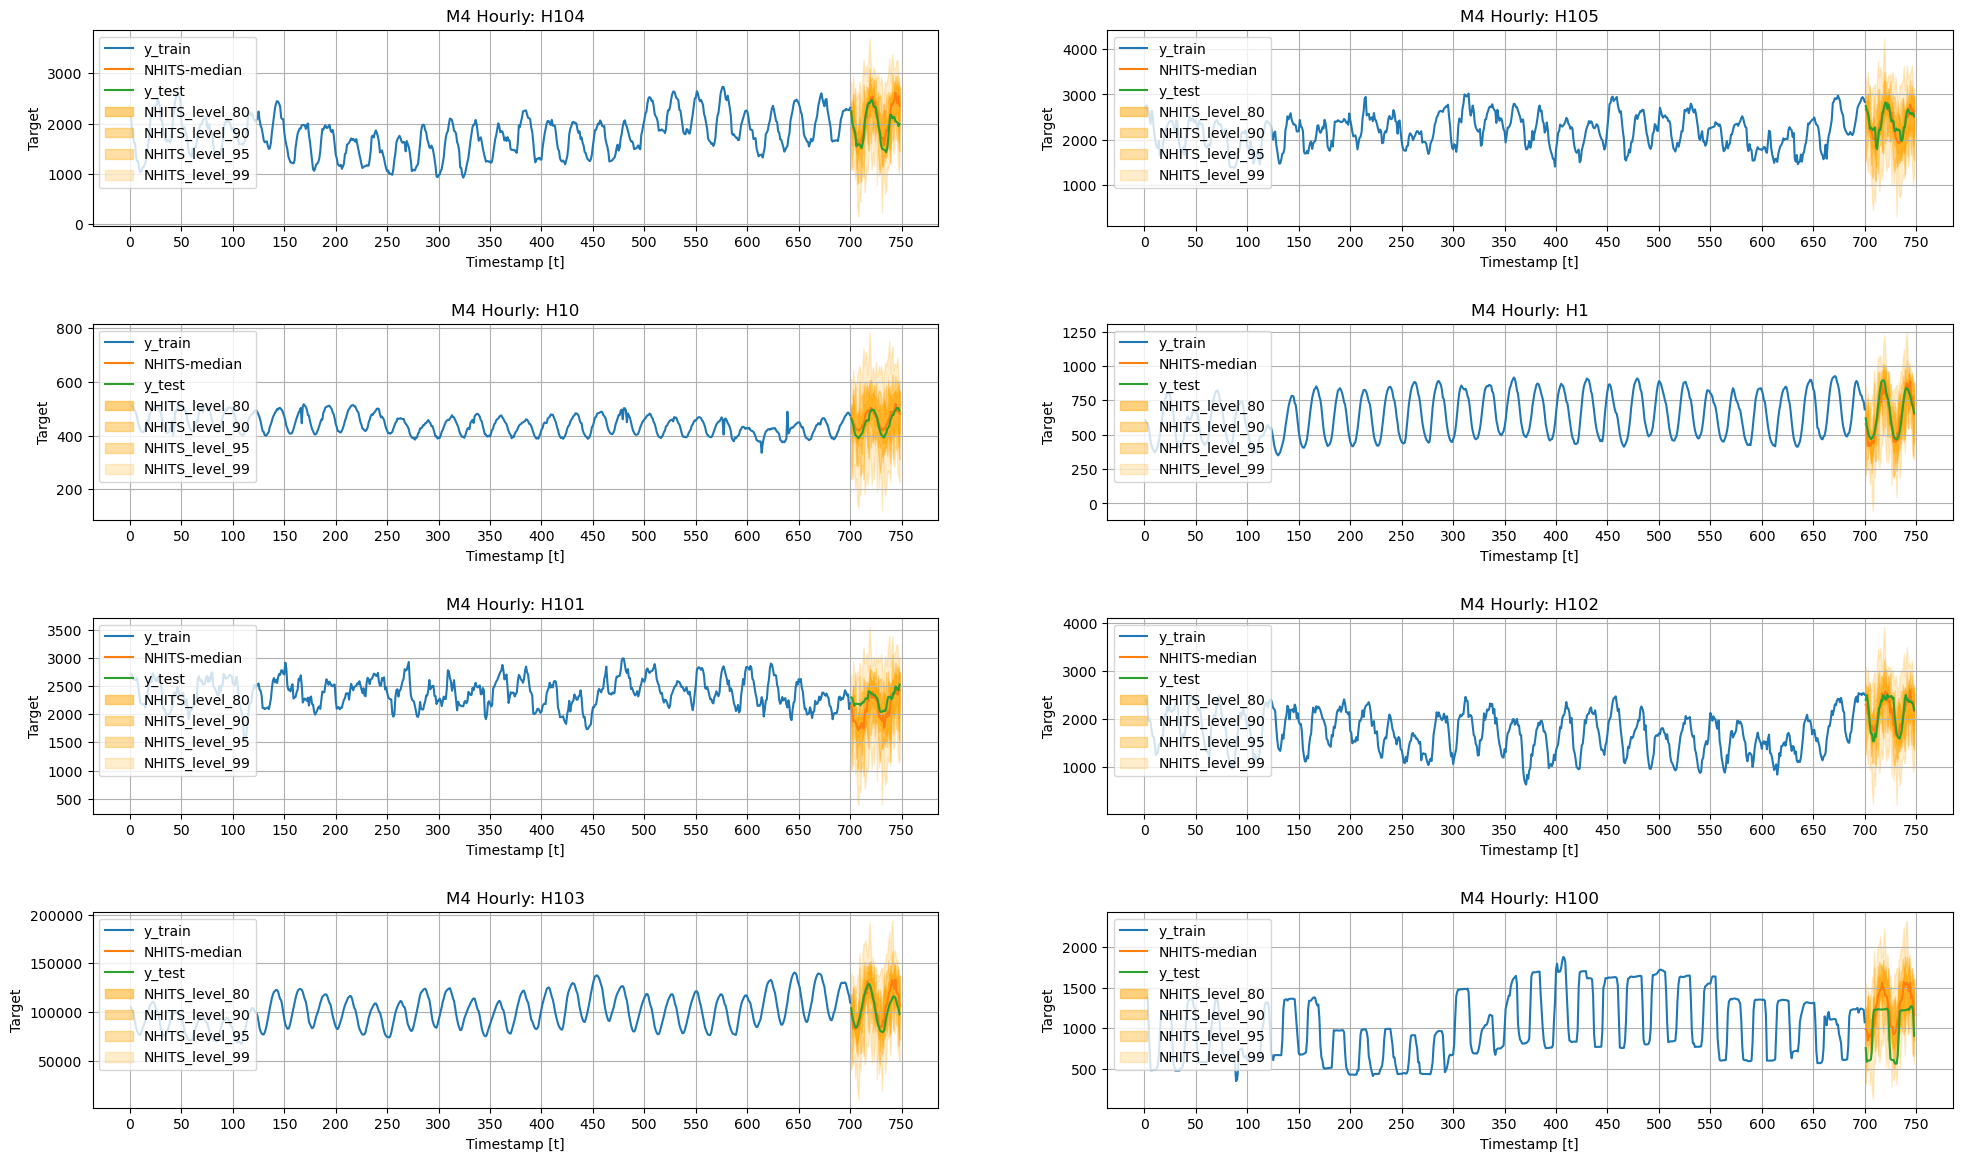

In [ ]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='NHITS')

## References
- [Roger Koenker and Gilbert Basset (1978). Regression Quantiles, Econometrica.](https://www.jstor.org/stable/1913643)
- [Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2020). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting". International Conference on Learning Representations.](https://arxiv.org/abs/1905.10437)
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). "N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting". Work in progress paper, submitted to AAAI.](https://arxiv.org/abs/2201.12886)